# Calculate along-slope velocity along the 1000 m isobath for easterly simulations
The simulations run from '2150-01-01' to '2164-12-31'

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import xgcm
import xarray.ufuncs as xu

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/easterlies/perturbation_check/'

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36197 Dashboard: /proxy/40195/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last 5 years of simulation:
start_time='2160-01-01'
end_time='2164-12-31'

lat_slice  = slice(-80,-58)

Bathymetry

In [4]:
# topography data for plotting (on u-grid):
hu = cc.querying.getvar(control,'hu' , master_session,n=1)
land_mask = np.squeeze(hu.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

hu = hu.sel(yu_ocean=lat_slice)

fontsize=16

Topographic gradient

In [5]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [6]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

In [7]:
# Calculate the magnitude of the topographic slope
slope = xu.sqrt(dhu_dx**2 + dhu_dy**2)

Grid cell thickness

In [8]:
u = cc.querying.getvar(control, 'u', master_session,frequency='1 monthly',start_time='2160-01-01', end_time='2160-01-31')
u = u.sel(yu_ocean=lat_slice).sel(time=slice('2160-01-01','2160-01-31'))

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':u.yu_ocean,'xu_ocean':u.xu_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

Load the isobath information

In [9]:
isobath_depth = 1000

file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_u_t_' + str(isobath_depth) + 'm_plt_approach.npz'
data = np.load(file_path)

# We are interested in the u-grid:
num_points = data['num_points_u']
distance_along_contour = data['distance_along_contour_u']
lon_along_contour = data['lon_along_contour_u']
lat_along_contour = data['lat_along_contour_u']

### Along-slope component along 1 km isobath


In [10]:
#%%time

def get_data_along_1km_isobath(expt, session):
    
    # Define empty array
    u_along_contour = np.zeros((12, len(u.st_ocean), len(lon_along_contour)))
    u_btr_contour   = np.zeros((12, len(lon_along_contour)))

    # Load data
    u_tmp = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
    u_tmp = u_tmp.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)
    v_tmp = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
    v_tmp = v_tmp.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)

    # Monthly climatology
    u_tmp  = u_tmp.groupby('time.month').mean('time')
    v_tmp  = v_tmp.groupby('time.month').mean('time')

    print(np.shape(u_tmp))

    # Rotate velocity
    u_along = u_tmp*dhu_dy/slope - v_tmp*dhu_dx/slope

    # Barotropic velocity
    u_btr = (u_along * thickness).sum('st_ocean') / thickness.sum('st_ocean')

    # Load data (takes time, but unfortunately required for selection of isobath points)
    u_along = u_along.load()
    u_btr   = u_btr.load()

    # Finally select velocity along contour 
    for ii in range(num_points):
        u_along_contour[:,:,ii] = u_along.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest')
    for ii in range(num_points):
        u_btr_contour[:,ii] = u_btr.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest')

#     u_along_contour_tmp = np.zeros((12, len(u_along.st_ocean), num_points))
#     for ii in range(num_points):
#         u_along_contour_tmp[:,:,ii] = u_along.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest')
#     u_btr_contour_tmp = np.zeros((12,num_points))
#     for ii in range(num_points):
#         u_btr_contour_tmp[:,ii] = u_btr.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest')

#     u_along_contour[yy,:,:,:] = u_along_contour_tmp
#     u_btr_contour[yy,:,:]     = u_btr_contour_tmp
            
    return u_along_contour, u_btr_contour

In [22]:
%%time
u_con, u_btr_con = get_data_along_1km_isobath(control, master_session)

(12, 75, 503, 3600)
CPU times: user 3min 16s, sys: 21.8 s, total: 3min 38s
Wall time: 4min 30s


In [30]:
u_down, u_btr_down = get_data_along_1km_isobath(easterlies_down, easterlies_session)

(12, 75, 503, 3600)


In [23]:
np.shape(u_con)

(12, 75, 4487)

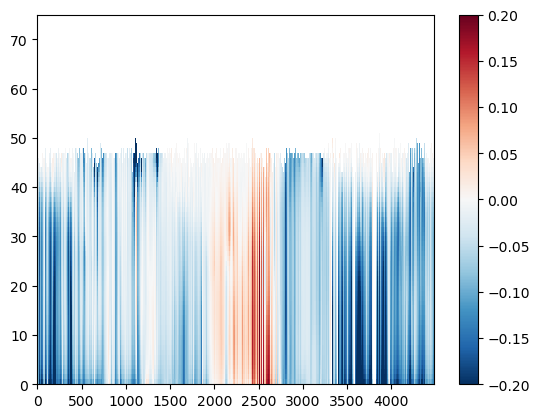

In [24]:
fig = plt.figure()

plt.pcolormesh(np.nanmean(u_con,axis=0), vmin=-0.2, vmax=0.2, cmap='RdBu_r')
plt.colorbar()

In [ ]:
# Grid cell thickness
thickness_contour = np.zeros((len(thickness.st_ocean), num_points))
for ii in range(num_points):
    thickness_contour[:,ii] = thickness.sel(xu_ocean=lon_along_contour[ii], method='nearest').sel(yu_ocean=lat_along_contour[ii], method='nearest')

In [31]:
import os
#save_dir  = '/g/data/x77/wgh581/Post_Process/'
#file_name = 'Antarctic_slope_contour_1km_velocities'
file_name = 'Antarctic_slope_1000m_contour_down'
outfile   = os.path.join(file_name+'.npz')

np.savez(outfile, u_along_contour=u_down, u_btr_contour=u_btr_down, \
         lat_along_contour=lat_along_contour, lon_along_contour=lon_along_contour, \
         num_points=num_points, distance_along_contour=distance_along_contour, \
         st_ocean=thickness.st_ocean, thickness_contour=thickness_contour)

---

Repeat for first year of model run

In [11]:
start_time='2150-01-01'
end_time='2150-12-31'

In [12]:
%%time
u_con, u_btr_con = get_data_along_1km_isobath(control, master_session)

(12, 75, 503, 3600)
CPU times: user 1min 19s, sys: 18 s, total: 1min 37s
Wall time: 2min 16s


In [13]:
u_up, u_btr_up = get_data_along_1km_isobath(easterlies_up, easterlies_session)

(12, 75, 503, 3600)


In [14]:
u_down, u_btr_down = get_data_along_1km_isobath(easterlies_down, easterlies_session)

(12, 75, 503, 3600)


Save data (without any extra information)

In [18]:
import os

file_name = 'Antarctic_slope_1000m_contour_year1_con'
outfile   = os.path.join(file_name+'.npz')

np.savez(outfile, u_along_contour=u_con, u_btr_contour=u_btr_con)